https://colab.research.google.com/github/JunetaeKim/GCSP-HBDA/blob/main/Week14/VADESC.ipynb

In [1]:
import sys
import os
import random
import pickle
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')
from tensorflow.keras.callbacks import ModelCheckpoint

sys.path.append(os.path.abspath("VADESC"))

from models.losses import Losses
from models.model import GMM_Survival
from utils.eval_utils import cindex_metric 
from utils.data_utils import get_gen
from lifelines import KaplanMeierFitter
from lifelines.utils import concordance_index


seed_num = 7
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

### Load sample dataset 

In [2]:
def load_npy_from_url(url):
    """
    Downloads a .npy file from a given URL and loads it as a NumPy array.

    Parameters:
        url (str): The URL of the .npy file (must be a Raw URL for GitHub files).

    Returns:
        np.ndarray: The loaded NumPy array.
    """
    try:
        # Download the file from the URL
        response = requests.get(url)
        response.raise_for_status()  # Raise HTTPError for bad responses (4xx or 5xx)

        # Save the content to a temporary file
        with open('temp.npy', 'wb') as temp_file:
            temp_file.write(response.content)

        # Load the NumPy array from the temporary file
        data = np.load('temp.npy', allow_pickle=True)
        return data

    except requests.exceptions.RequestException as e:
        print(f"Error fetching the file: {e}")
        return None
    except Exception as e:
        print(f"Error loading the .npy file: {e}")
        return None

In [3]:
url_X_train = 'https://raw.githubusercontent.com/JunetaeKim/GCSP-HBDA/main/Week11/Data/X_train.npy'
url_X_val = 'https://raw.githubusercontent.com/JunetaeKim/GCSP-HBDA/main/Week11/Data/X_val.npy'
url_y_train = 'https://raw.githubusercontent.com/JunetaeKim/GCSP-HBDA/main/Week11/Data/y_train.npy'
url_y_val = 'https://raw.githubusercontent.com/JunetaeKim/GCSP-HBDA/main/Week11/Data/y_val.npy'

X_train = load_npy_from_url(url_X_train)
X_val = load_npy_from_url(url_X_val)
y_train = load_npy_from_url(url_y_train)[:, :2]
y_val = load_npy_from_url(url_y_val)[:, :2]

# This is an arbitrary method to facilitate the research setup and is not a standard approach. Please keep this in mind.
y_train[:, 0]= y_train[:, 0] * 200
y_val[:, 0]= y_val[:, 0] * 200

# GitHub Raw URL
response = requests.get('https://raw.githubusercontent.com/JunetaeKim/GCSP-HBDA/main/Week11/Data/x_varlist.pkl')
x_varlist = pickle.loads(response.content)


X_train_DF = pd.DataFrame(X_train, columns=x_varlist)
X_val_DF = pd.DataFrame(X_val, columns=x_varlist)
Y_train_DF = pd.DataFrame(y_train, columns=['time','event'])
Y_val_DF = pd.DataFrame(y_val, columns=['time','event'])

### Parameter setting for the experiment

In [5]:
configs = {'global_param': {'batch_size': 1400,
  'data_type': 'TCGA',
  'data_path': '../../Data/TCGA/ProcessedData/AnalData.csv',
  'weight_save_path': './ModelSave/',
  'result_tracking_path': './Tracking/',
  'seed': 7},
 'training': {'eval_frequency': 200,
  'n_epochs': 3000,
  'inp_shape': 1173,
  'latent_dim': 16,
  'activation': 'sigmoid',
  'monte_carlo': 1,
  'num_clusters': 8,
  'learn_prior': True,
  'weibull_shape': 1,
  'survival': True,
  'sample_surv': True},
 'eval_param': {'num_coef': 30}}

### VaDeSC Model

In [6]:
# Define reconstruction loss function
losses = Losses(configs)
rec_loss = losses.loss_reconstruction_mse

# Construct the model & optimizer
model = GMM_Survival(**configs['training'])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, decay=0.00001)
model.compile(optimizer, loss={"output_1": rec_loss}, metrics={ "output_5": cindex_metric})
# Use survival times during training
tf.keras.backend.set_value(model.use_t, np.array([1.0]))

# Data generators
gen_train = get_gen(X_train, y_train, configs, configs['global_param']['batch_size'])
gen_test = get_gen(X_val, y_val, configs, y_val.shape[0], validation=True)
gen_train.X.shape, gen_train.y.shape, gen_test.X.shape, gen_test.y.shape

((4173, 1173), (4173, 2), (1391, 1173), (1391, 2))

In [7]:
# Set up model checkpoint
checkpoint = ModelCheckpoint(
    filepath='./Save/VADESC.h5',  # File path to save the model
    monitor='val_loss',                             # Metric to monitor (validation loss)
    save_best_only=True,                            # Save only the best model based on the monitored metric
    save_weights_only=True,                        # Save the entire model (set True to save only weights)
    mode='min',                                     # Save when 'val_loss' is minimized
    verbose=1                                       # Print messages when the model is saved
)


### Training & Evaluation

In [8]:
# Fit the model
history = model.fit(gen_train, validation_data=gen_test, epochs=configs['training']['n_epochs'], callbacks=[checkpoint], verbose=2)
#history = model.fit(gen_train, validation_data=gen_test, epochs=100, callbacks=[checkpoint], verbose=2)

Epoch 1/3000
Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.

Epoch 1: val_loss improved from inf to 71.81956, saving model to ./Save\VADESC.h5
2/2 - 6s - loss: 82.1477 - output_1_loss: 56.1244 - output_5_cindex_metric: 0.6526 - loss_clustering: 28.9477 - loss_prior: 0.2079 - loss_variational_1: -9.5763e+00 - loss_variational_2: -7.3945e-01 - loss_survival: 7.1834 - val_loss: 71.8196 - val_output_1_loss: 54.9356 - val_output_5_cindex_metric: 0.6858 - val_loss_clustering: 15.4355 - val_loss_prior: 0.2078 - val_loss_variational_1: -8.6820e+00 - val_loss_variational_2: -1.0977e+00 - val_loss_survival: 11.0202 - 6s/epoch - 3s/step
Epoch 2/3000

Epoch 2: val_loss improved from 71.81956 to 46.62955, saving model to ./Save\VADESC.h5
2/2 - 0s - loss: 67.9771 - output_1_loss: 45.3202 - output_5_cindex_metric: 0.6292 - loss_clustering: 25.3541 - loss_prior: 0.2079 - loss_variational_1: -9.6306e+00 - loss_variational_2: -


KeyboardInterrupt



In [10]:
model((gen_test.X[:1], gen_test.y[:1]))
model.load_weights('./Save/VADESC.h5')

In [11]:
# Evaluate the model 

# Don't use survival times during testing
tf.keras.backend.set_value(model.use_t, np.array([0.0]))

# Don't use MC samples to predict survival at evaluation
model.sample_surv = False

# Hard cluster assignments
rec, z_sample, p_z_c, p_c_z, risk_scores, lambdas = model.predict((X_train, y_train), batch_size=256)
val_labels_v = np.argmax(p_c_z, axis=-1)
rec, z_sample, p_z_c, p_c_z, risk_scores, lambdas = model.predict((X_val, y_val), batch_size=256)
test_labels_v = np.argmax(p_c_z, axis=-1)

np.unique(val_labels_v, return_counts=True), np.unique(test_labels_v, return_counts=True)

6/6 [==============================] - 0s 10ms/step


((array([2], dtype=int64), array([4173], dtype=int64)),
 (array([2], dtype=int64), array([1391], dtype=int64)))

In [12]:
def plot_survival_function(time, event, labels_v, labels_w=None, show_live=True, timeline=np.arange(0, 4000, 100), epoch=None, save=False):
    """
    Plots the survival function for different clusters and returns the plot as base64.
    
    Args:
        time (tensor): Time tensor (batch_size).
        event (tensor): Event tensor (batch_size).
        labels_v (tensor): Cluster labels for V (batch_size).
        labels_w (tensor, optional): Cluster labels for W (batch_size). Default is None.
        show_live (bool): Whether to show the plot live.
        timeline (array): Timeline for the survival plot.
        epoch (int, optional): Current epoch number.
        save (bool): Whether to save the plot.
    """
    CB_COLOR_CYCLE = [
        '#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00',
        '#ff0000', '#ff8000', '#ffff00', '#80ff00', '#00ff00', '#00ff80', '#00ffff', '#0080ff', '#0000ff',
        '#8000ff', '#ff00ff', '#ff0080', '#ffb3b3', '#b3ffb3', '#b3b3ff', '#ff66b3', '#66ffb3', '#b366ff',
        '#ff6666', '#66ff66', '#6666ff', '#ffcc66', '#66ffcc', '#cc66ff'
    ]

    # Create subplots based on the availability of labels_w
    if labels_w is not None:
        fig, axs = plt.subplots(1, 2, figsize=(8, 3))
    else:
        fig, ax = plt.subplots(1, 1, figsize=(5, 4))
        axs = [ax]  # To unify the handling of axs as a list
    
    # Plot for labels_v
    for lab in np.unique(labels_v):
        kmf = KaplanMeierFitter()
        kmf.fit(time[labels_v == lab], event[labels_v == lab], label=f"Cluster V {int(lab + 1)}", timeline=timeline)
        kmf.plot(ax=axs[0], ci_show=True, color=CB_COLOR_CYCLE[int(lab)])
    axs[0].set_title('Survival Function for Labels V')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Survival Probability')

    # Plot for labels_w (if available)
    if labels_w is not None:
        for lab in np.unique(labels_w):
            kmf = KaplanMeierFitter()
            kmf.fit(time[labels_w == lab], event[labels_w == lab], label=f"Cluster W {int(lab + 1)}", timeline=timeline)
            kmf.plot(ax=axs[1], ci_show=True, color=CB_COLOR_CYCLE[int(lab)])
        axs[1].set_title('Survival Function for Labels W')
        axs[1].set_xlabel('Time')
        axs[1].set_ylabel('Survival Probability')
    
    # Save or show the plot
    if save:
        plt.tight_layout()
        buf = BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        img_str = base64.b64encode(buf.read()).decode('utf-8')
        if show_live:
            plt.show()
        plt.close(fig)
        return f'data:image/png;base64,{img_str}'
    else:
        plt.tight_layout()
        plt.show()
        

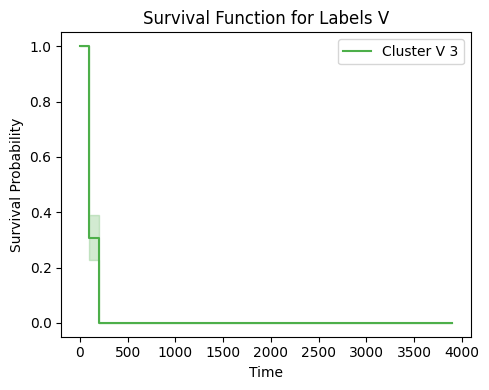

In [13]:
%matplotlib inline
plot_survival_function(y_val[:, 0], y_val[:, 1], test_labels_v, epoch=None, show_live=True, save=False)

#### From deep learing 

In [14]:
# concordance_index(event_times=y_test[:, 0], event_observed=y_test[:, 1], predicted_scores=risk_scores)

rec, z_sample, p_z_c, p_c_z, risk_scores, lambdas = model.predict((X_train, y_train), batch_size=256)
concordance_index(event_times=y_train[:, 0], event_observed=y_train[:, 1], predicted_scores=risk_scores)

17/17 [==============================] - 0s 10ms/step


0.49118497423969043